In [ ]:
!pip install qutip

In [ ]:
!pip install krotov

In [ ]:
import sys
import os
import qutip
import numpy as np
import scipy
import matplotlib
import matplotlib.pylab as plt
import krotov
from scipy.fftpack import fft
from scipy.interpolate import interp1d
from qutip.control import *

In [ ]:
# Pauli matrices
sigma_x = np.array([[0, 1], [1, 0]])
sigma_y = np.array([[0, -1.j], [1.j, 0]])
sigma_z = np.array([[1, 0], [0, -1]])

Isigma_z = np.array([[1, 0, 0, 0],
           [0, -1, 0, 0],
           [0, 0, 1, 0],
           [0, 0, 0, -1]])

sigma_zI =np.array( [[1, 0, 0, 0],
           [0, 1, 0, 0],
           [0, 0, -1, 0],
           [0, 0, 0, -1]])

Isigma_x = np.array([[0, 1, 0, 0],
           [1, 0, 0, 0],
           [0, 0, 0, 1],
           [0, 0, 1, 0]])

sigma_xI = np.array([[0, 0, 1, 0],
           [0, 0, 0, 1],
           [1, 0, 0, 0],
           [0, 1, 0, 0]])
Isigma_y = np.array([[0, -1.j, 0, 0],
           [1.j, 0, 0, 0],
           [0, 0, 0, -1.j],
           [0, 0, 1.j, 0]])

sigma_yI = np.array([[0, 0, -1.j, 0],
           [0, 0, 0, -1.j],
           [1.j, 0, 0, 0],
           [0, 1.j, 0, 0]])

sigma_x_x = np.array([[0, 0, 0, 1],
           [0, 0, 1, 0],
           [0, 1, 0, 0],
           [1, 0, 0, 0]])

sigma_y_y = np.array([[0, 0, 0, -1],
           [0, 0, 1, 0],
           [0, 1, 0, 0],
           [-1, 0, 0, 0]])

sigma_z_z = np.array([[1, 0, 0, 0],
           [0, -1, 0, 0],
           [0, 0, -1, 0],
           [0, 0, 0, 1]])


In [ ]:
def hamiltonian(omega1=1 ,omega2=1, ampl0=0.2, J=0.01 ):
    H0 = qutip.Qobj((-0.5) *( omega1 * Isigma_z +  omega2 * sigma_zI )
    + J* (sigma_z_z))
    H1 = qutip.Qobj(Isigma_x)

    def guess_control(t , args):
        return ampl0 * krotov.shapes.flattop(
            t, t_start=0, t_stop=300, t_rise=0.3, func="blackman"
        )
    return [H0,[H1,guess_control]]


In [ ]:
H = hamiltonian()
H

[Quantum object: dims = [[4], [4]], shape = (4, 4), type = oper, isherm = True
 Qobj data =
 [[-0.99  0.    0.    0.  ]
  [ 0.   -0.01  0.    0.  ]
  [ 0.    0.   -0.01  0.  ]
  [ 0.    0.    0.    1.01]],
 [Quantum object: dims = [[4], [4]], shape = (4, 4), type = oper, isherm = True
  Qobj data =
  [[0. 1. 0. 0.]
   [1. 0. 0. 0.]
   [0. 0. 0. 1.]
   [0. 0. 1. 0.]],
  <function __main__.hamiltonian.<locals>.guess_control(t, args)>]]

In [ ]:
T = 300
N = 3000
dt = T/N
omega1=1
omega2=1
J=0.01

In [ ]:
tlist = np.linspace(0, T, N)

In [ ]:
def logical_basis(H):
    H0 = qutip.Qobj((-0.5) *(1 * Isigma_z +  1 * sigma_zI ))
    eigenvals, eigenvecs = scipy.linalg.eig(H0.full())
    ndx = np.argsort(eigenvals.real)
    E = eigenvals[ndx].real
    V = eigenvecs[:, ndx]
    psi00 = qutip.Qobj(V[:, 0])
    psi01 = qutip.Qobj(V[:, 1])
    psi10 = qutip.Qobj(V[:, 2])
    psi11 = qutip.Qobj(V[:, 3])
    w01 = E[1] - E[0]  # Transition energy between states
    print("Energy of qubit transition is %.3f" % w01)
    return psi00, psi01, psi10, psi11

psi00, psi01, psi10, psi11 = logical_basis(H)

Energy of qubit transition is 1.000


In [ ]:
proj00 = qutip.ket2dm(psi00)
proj01 = qutip.ket2dm(psi01)
proj10 = qutip.ket2dm(psi10)
proj11 = qutip.ket2dm(psi11)

In [ ]:
basis = [psi00, psi01, psi10, psi11]
basis

[Quantum object: dims = [[4], [1]], shape = (4, 1), type = ket
 Qobj data =
 [[1.]
  [0.]
  [0.]
  [0.]], Quantum object: dims = [[4], [1]], shape = (4, 1), type = ket
 Qobj data =
 [[0.]
  [1.]
  [0.]
  [0.]], Quantum object: dims = [[4], [1]], shape = (4, 1), type = ket
 Qobj data =
 [[0.]
  [0.]
  [1.]
  [0.]], Quantum object: dims = [[4], [1]], shape = (4, 1), type = ket
 Qobj data =
 [[0.]
  [0.]
  [0.]
  [1.]]]

In [ ]:
CNOT= np.array([[1, 0, 0, 0],
           [0, 1, 0, 0],
           [0, 0, 0, 1],
           [0, 0, 1, 0]])

In [ ]:
objectives = krotov.gate_objectives(
    basis_states=[psi00, psi01, psi10, psi11], gate=CNOT, H=H
)

objectives

[Objective[|Ψ₀(4)⟩ to |Ψ₀(4)⟩ via [H₀[4,4], [H₁[4,4], u₁(t)]]],
 Objective[|Ψ₁(4)⟩ to |Ψ₁(4)⟩ via [H₀[4,4], [H₁[4,4], u₁(t)]]],
 Objective[|Ψ₂(4)⟩ to |Ψ₃(4)⟩ via [H₀[4,4], [H₁[4,4], u₁(t)]]],
 Objective[|Ψ₃(4)⟩ to |Ψ₂(4)⟩ via [H₀[4,4], [H₁[4,4], u₁(t)]]]]

In [ ]:
def plot_population(result):
    '''Representation of the expected values for the initial states'''
    fig, ax = plt.subplots()
    ax.plot(result.times, result.expect[0], label='00')
    ax.plot(result.times, result.expect[1], label='01')
    ax.plot(result.times, result.expect[2], label='10')
    ax.plot(result.times, result.expect[3], label='11')
    ax.legend()
    ax.set_xlabel('time')
    ax.set_ylabel('population')
    plt.show(fig)

In [ ]:
def S(t):
    """Scales the Krotov methods update of the pulse value at the time t"""
    return krotov.shapes.flattop(
        t, t_start=0, t_stop=300, t_rise=0.3, t_fall=0.3, func='blackman'
    )

pulse_options = {H[1][1]: dict(lambda_a=1, update_shape=S)}

In [ ]:
opt_result = krotov.optimize.optimize_pulses(
    objectives,
    pulse_options=pulse_options,
    tlist=tlist,
    propagator=krotov.propagators.expm,
    chi_constructor=krotov.functionals.chis_sm,
    info_hook=krotov.info_hooks.print_table(J_T=krotov.functionals.J_T_sm),
    check_convergence=krotov.convergence.Or(
        krotov.convergence.value_below('1e-3', name='J_T'),
        krotov.convergence.delta_below(1e-5),
        krotov.convergence.check_monotonic_error,
    ),
    store_all_pulses=True,

)

iter.      J_T    ∫gₐ(t)dt          J       ΔJ_T         ΔJ  secs
0     9.93e-01    0.00e+00   9.93e-01        n/a        n/a    39
1     4.36e-02    7.28e-02   1.16e-01  -9.50e-01  -8.77e-01    82
2     1.61e-02    1.37e-02   2.98e-02  -2.75e-02  -1.38e-02    79
3     9.55e-03    3.29e-03   1.28e-02  -6.58e-03  -3.29e-03    81
4     5.47e-03    2.04e-03   7.51e-03  -4.08e-03  -2.04e-03    80
5     2.91e-03    1.28e-03   4.19e-03  -2.56e-03  -1.28e-03    79
6     1.66e-03    6.25e-04   2.29e-03  -1.25e-03  -6.24e-04    80
7     9.40e-04    3.62e-04   1.30e-03  -7.23e-04  -3.61e-04    80


In [ ]:
opt_result

Krotov Optimization Result
--------------------------
- Started at 2023-02-26 06:33:15
- Number of objectives: 4
- Number of iterations: 7
- Reason for termination: Reached convergence: J_T < 1e-3
- Ended at 2023-02-26 06:43:19 (0:10:04)

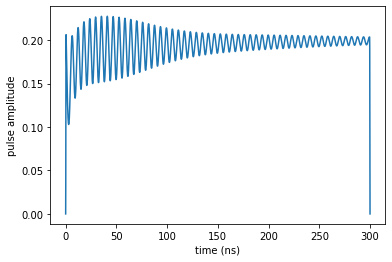

In [ ]:
plot_pulse(opt_result.optimized_controls[0], tlist)

In [ ]:
opt_dynamics1 = opt_result.optimized_objectives[0].mesolve(
    tlist, e_ops=[proj00, proj01, proj10, proj11])
opt_dynamics2 = opt_result.optimized_objectives[1].mesolve(
    tlist, e_ops=[proj00, proj01, proj10, proj11])
opt_dynamics3 = opt_result.optimized_objectives[2].mesolve(
    tlist, e_ops=[proj00, proj01, proj10, proj11])
opt_dynamics4 = opt_result.optimized_objectives[3].mesolve(
    tlist, e_ops=[proj00, proj01, proj10, proj11])

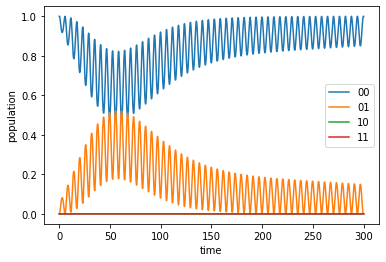

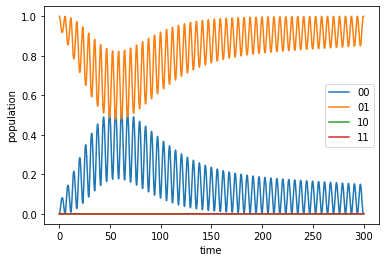

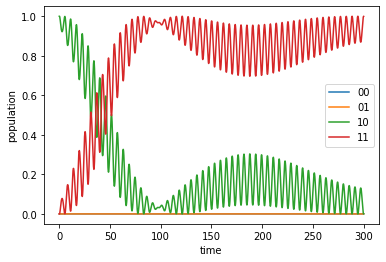

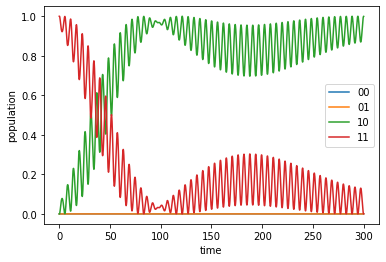

In [ ]:
plot_population(opt_dynamics1)
plot_population(opt_dynamics2)
plot_population(opt_dynamics3)
plot_population(opt_dynamics4)